In [2]:
import numpy as np
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load npz file and inspect its folder structure.

In [3]:
npz = np.load('/kaggle/input/plants/public_data.npz', allow_pickle=True)
print(npz.files)

['data', 'labels']


In [4]:
data = npz['data']
labels = npz['labels']

## Check out the shapes of the data and their labels.

In [5]:
data.shape

(5200, 96, 96, 3)

In [6]:
labels.shape

(5200,)

## Select a sample data and check the minimum and maximum values provided to see if the image is already normalised or not.

In [7]:
sample = data[0]
print('Min:', sample.min(), 'Max:', sample.max())

Min: 0.0 Max: 255.0


In [8]:
labels

array(['healthy', 'healthy', 'healthy', ..., 'healthy', 'healthy',
       'healthy'], dtype=object)

## Convert string labels into numerical values.

In [9]:
binary_labels = np.array([0 if label == 'healthy' else 1 for label in labels])

## Display 10 healthy and 10 unhealthy images to try to visually spot apparent distinctions.

Healthy Plant Images:


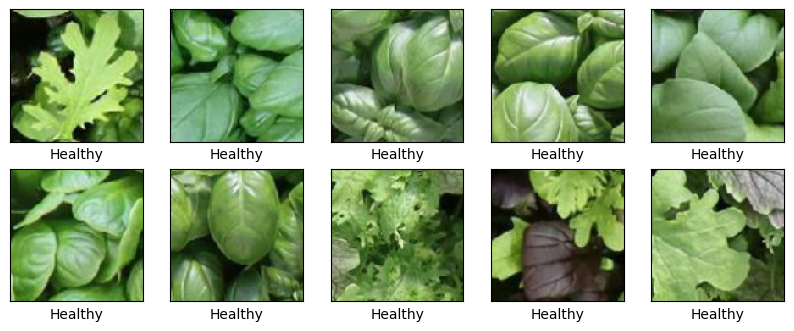

Unhealthy Plant Images:


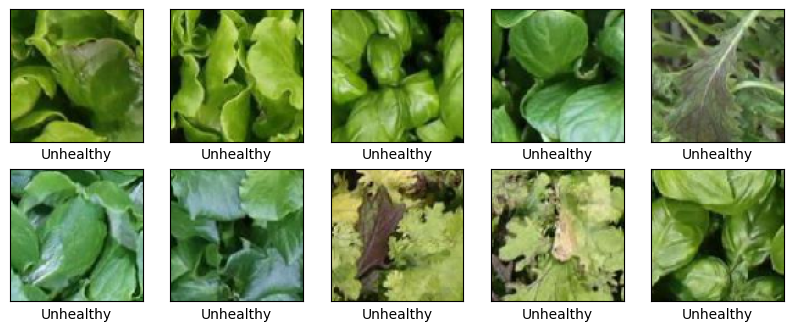

In [10]:
import matplotlib.pyplot as plt

def show_images(images, labels, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i]/255.0)
        plt.xlabel('Healthy' if labels[i] == 0 else 'Unhealthy')
    plt.show()

# Filter out 10 healthy and 10 unhealthy images
healthy_images = data[binary_labels == 0][:10]
unhealthy_images = data[binary_labels == 1][:10]

# Display healthy images
print("Healthy Plant Images:")
show_images(healthy_images, [0]*10)

# Display unhealthy images
print("Unhealthy Plant Images:")
show_images(unhealthy_images, [1]*10)

## Count the data for each label in order to spot if class balancing is needed.

In [11]:
label_counts = np.bincount(binary_labels)
print(f"Number of healthy plants (label 1): {label_counts[0]}")
print(f"Number of unhealthy plants (label 0): {label_counts[1]}")

Number of healthy plants (label 1): 3199
Number of unhealthy plants (label 0): 2001


## Normalise the data into [0, 1]. 
## Then check if the normalisation is successful.

In [12]:
#normalisation
normalised = data/255.0

sample = normalised[0]
print('Min:', sample.min(), 'Max:', sample.max())

Min: 0.0 Max: 1.0


## Split the dataset into train, validation and test sets.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(normalised, binary_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

## Apply data augmentation.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=32

# Create an instance of ImageDataGenerator with desired augmentations
data_gen = ImageDataGenerator(
    rotation_range=20,       # Degree range for random rotations
    width_shift_range=0.2,   # Range (as a fraction of total width) for horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for vertical shifts
    shear_range=0.2,         # Shear Intensity (Shear angle in counter-clockwise direction)
    zoom_range=0.2,          # Range for random zoom
    horizontal_flip=True,    # Randomly flip inputs horizontally
    fill_mode='nearest'      # Strategy for filling in newly created pixels
)

# Apply the data generator to the training data
train_generator = data_gen.flow(X_train, y_train, batch_size=batch_size)

## Compute class weights to balance the dataset.

In [15]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights: {class_weights_dict}")

Class weights: {0: 0.8157776781712237, 1: 1.2916962384669979}


In [16]:
from tensorflow.keras.models import load_model

class model:
    def __init__(self, path):
        self.model = load_model(path)
        
    def predict(self, X):
        X_processed = self._preprocess(X)
        predictions = self.model.predict(X_processed)
        predictions = self._postprocess(predictions)
        return predictions
    
    def _preprocess(self, X):
        return X.astype('float32') / 255.0
    
    def _postprocess(self, predictions):
        return (predictions > 0.5).astype(int)

## Load base models for transfer learning.
### ResNet50 and VGG16 has been tried in this notebook.

## Then add custom layers to create our final model.

In [17]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
'''
# Load the ResNet50 model pre-trained on ImageNet data, excluding the top classification layer
base_model = ResNet50(weights=None, include_top=False, input_shape=(96, 96, 3))
base_model.load_weights('/kaggle/input/resnet50-imagenet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze the base_model, only train the layers that we will add
base_model.trainable = False

# Create a new model on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)  # Add a fully connected layer with a sigmoid function for binary classification

# This is the new model we will train
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
'''

# Load VGG16 pre-trained on ImageNet data, excluding the top classification layer
base_model = VGG16(weights=None, include_top=False, input_shape=(96, 96, 3))
base_model.load_weights('/kaggle/input/vgg16-imagenet/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

base_model.trainable = False  # Freeze the base_model

# Add custom layers on top for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

## Fit the model.

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set the number of epochs 
epochs = 20

# Define the EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator, 
    epochs=epochs, 
    #batch_size=batch_size, 
    validation_data=(X_val, y_val), 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Load the best saved model
model.load_weights('/kaggle/working/best_model.h5')

Epoch 1/20
114/114 [==============================] - 18s 97ms/step - loss: 0.5892 - accuracy: 0.6681 - val_loss: 0.5722 - val_accuracy: 0.6962
Epoch 2/20
114/114 [==============================] - 10s 92ms/step - loss: 0.5411 - accuracy: 0.7099 - val_loss: 0.5240 - val_accuracy: 0.7333
Epoch 3/20
114/114 [==============================] - 10s 89ms/step - loss: 0.5245 - accuracy: 0.7264 - val_loss: 0.5637 - val_accuracy: 0.7026
Epoch 4/20
114/114 [==============================] - 10s 91ms/step - loss: 0.5076 - accuracy: 0.7445 - val_loss: 0.6292 - val_accuracy: 0.6282
Epoch 5/20
114/114 [==============================] - 10s 91ms/step - loss: 0.5109 - accuracy: 0.7352 - val_loss: 0.4639 - val_accuracy: 0.7782
Epoch 6/20
114/114 [==============================] - 10s 89ms/step - loss: 0.4748 - accuracy: 0.7602 - val_loss: 0.5424 - val_accuracy: 0.7192
Epoch 7/20
114/114 [==============================] - 10s 91ms/step - loss: 0.4856 - accuracy: 0.7508 - val_loss: 0.4550 - val_accuracy:

## Plot validation loss and accuracy to monitor the model's performance and generalization on unseen data over time during training.

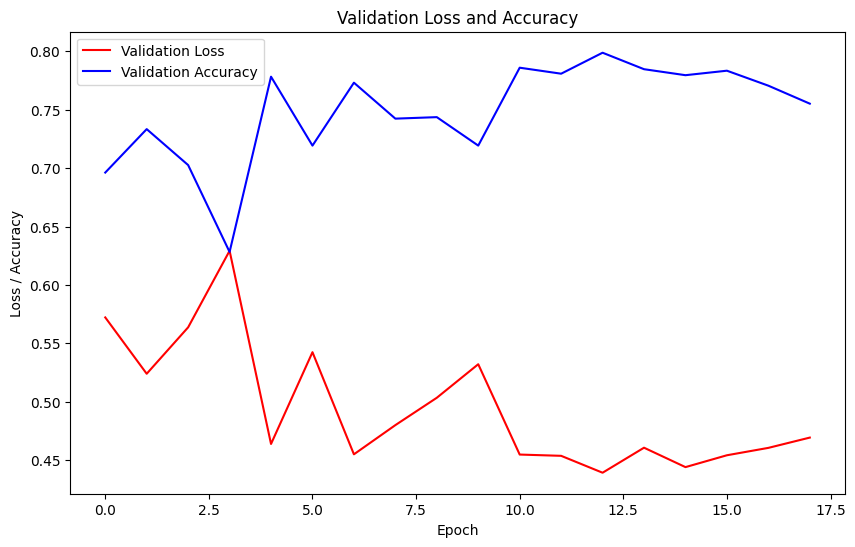

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting validation loss
plt.plot(history.history['val_loss'], color='red', label='Validation Loss')

# Plotting validation accuracy
# Assuming val_accuracy is a percentage, it's multiplied by 100 for scaling
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')

plt.title('Validation Loss and Accuracy')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [30]:
predictions = model.predict(X_test)

# Converting probabilities to class labels
y_pred = (predictions > 0.5).astype('int32').flatten()

25/25 [==============================] - 0s 14ms/step


## Plot confusion matrix to visually assess the model's classification accuracy and its behavior across different classes.

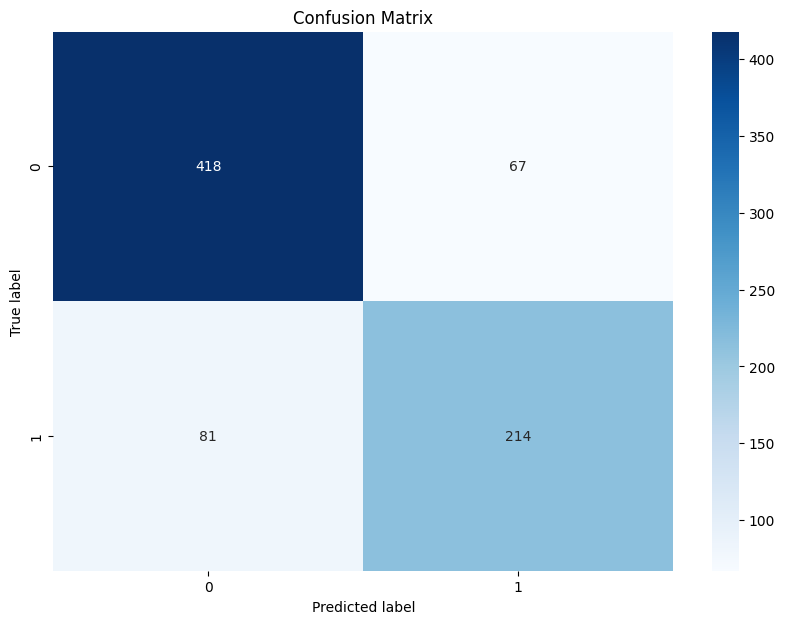

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Plot the histogram of predicted probabilities to evaluate the model's confidence in its predictions and to identify potential thresholds for classification.

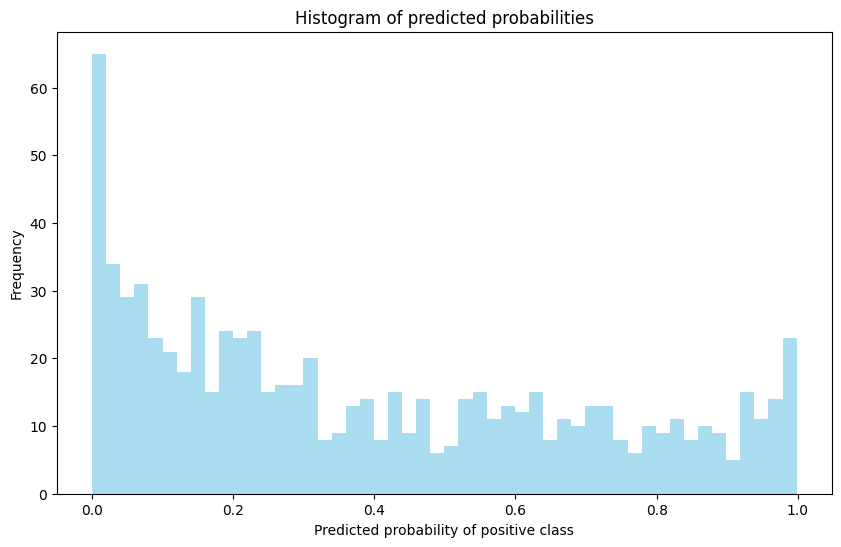

In [33]:
# Plot a histogram of the predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=50, color='skyblue', alpha=0.7)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of positive class')
plt.ylabel('Frequency')
plt.show()


## Model evaluation with accuracy

In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

25/25 [==============================] - 0s 15ms/step - loss: 0.4932 - accuracy: 0.7679
Test loss: 0.4931710958480835
Test accuracy: 0.7679487466812134


## Unfreeze some of the layers to finetune the model.

In [19]:
# Unfreeze the base_model, to improve accuracy
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Choose how many layers to unfreeze
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  19


In [20]:
model.compile(optimizer=Adam(learning_rate=1e-6),  # Use a lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Fit again.

In [21]:
fine_tune_epochs = 10
total_epochs = fine_tune_epochs + epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,  # Total number of epochs to train for
    initial_epoch=history.epoch[-1],  # Start from the last epoch of the previous training session
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 10/30
114/114 [==============================] - 14s 93ms/step - loss: 0.5004 - accuracy: 0.7475 - val_loss: 0.4816 - val_accuracy: 0.7679
Epoch 11/30
114/114 [==============================] - 11s 92ms/step - loss: 0.4943 - accuracy: 0.7527 - val_loss: 0.4767 - val_accuracy: 0.7718
Epoch 12/30
114/114 [==============================] - 11s 92ms/step - loss: 0.4958 - accuracy: 0.7522 - val_loss: 0.4700 - val_accuracy: 0.7782
Epoch 13/30
114/114 [==============================] - 10s 90ms/step - loss: 0.4965 - accuracy: 0.7470 - val_loss: 0.4685 - val_accuracy: 0.7718
Epoch 14/30
114/114 [==============================] - 10s 90ms/step - loss: 0.4856 - accuracy: 0.7522 - val_loss: 0.4691 - val_accuracy: 0.7692
Epoch 15/30
114/114 [==============================] - 10s 88ms/step - loss: 0.4777 - accuracy: 0.7599 - val_loss: 0.4780 - val_accuracy: 0.7718
Epoch 16/30
114/114 [==============================] - 10s 89ms/step - loss: 0.4736 - accuracy: 0.7571 - val_loss: 0.4657 - val_ac

In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

25/25 [==============================] - 0s 15ms/step - loss: 0.4555 - accuracy: 0.7872
Test loss: 0.45552924275398254
Test accuracy: 0.7871794700622559


In [26]:
model.save('/kaggle/working/vgg16_2')

In [27]:
!zip -r vgg2.zip /kaggle/working/vgg16_2

  adding: kaggle/working/vgg16_2/ (stored 0%)
  adding: kaggle/working/vgg16_2/assets/ (stored 0%)
  adding: kaggle/working/vgg16_2/keras_metadata.pb (deflated 95%)
  adding: kaggle/working/vgg16_2/fingerprint.pb (stored 0%)
  adding: kaggle/working/vgg16_2/variables/ (stored 0%)
  adding: kaggle/working/vgg16_2/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/vgg16_2/variables/variables.index (deflated 69%)
  adding: kaggle/working/vgg16_2/saved_model.pb (deflated 90%)
